### An Efficient Stacking Ensemble Model for Monthly Rainfall Prediction: A Comparative Study

In [929]:
import pandas as pd

df = pd.read_csv('MLSP.csv')
df.head()

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000,1,1,8.06,48.25,23.93,0.00
1,2000,2,1,8.73,50.81,25.83,0.11
2,2000,3,1,8.48,42.88,26.68,0.01
3,2000,4,1,13.79,55.69,22.49,0.02
4,2000,5,1,17.40,70.88,19.07,271.14


In [931]:
df.shape

(252, 7)

In [933]:
Timestamp = pd.to_datetime(df[['Year', 'Month', 'Day']])
Timestamp

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
247   2020-08-01
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
Length: 252, dtype: datetime64[ns]

In [935]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               252 non-null    int64  
 1   Month              252 non-null    int64  
 2   Day                252 non-null    int64  
 3   Specific Humidity  252 non-null    float64
 4   Relative Humidity  252 non-null    float64
 5   Temperature        252 non-null    float64
 6   Precipitation      252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


<Axes: >

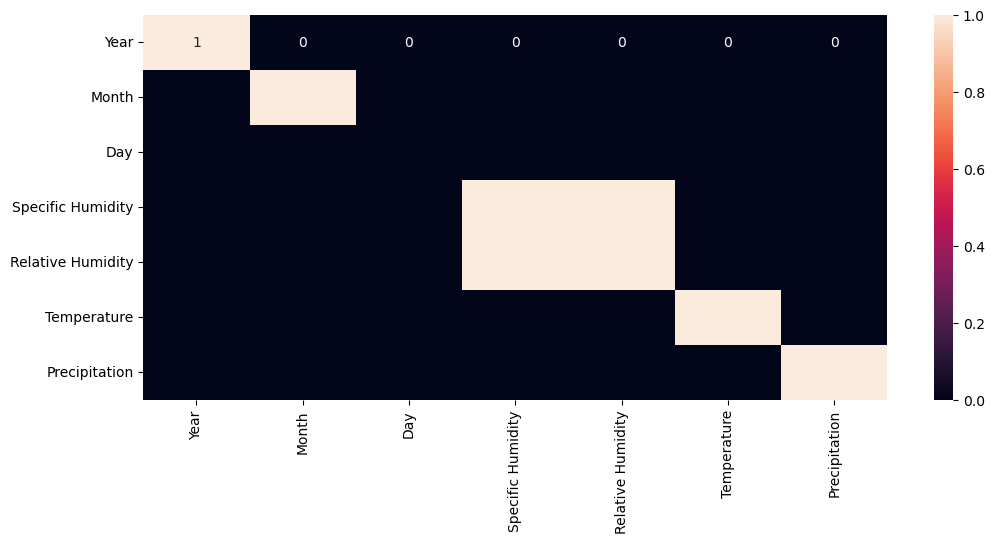

In [937]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,5))
sns.heatmap(df.corr()>0.80,annot=True)

#ells with True: These indicate pairs of features with a correlation coefficient greater than 0.80. 
#Such features are highly correlated and may carry redundant information.Diagonal: The diagonal will
#always have True values because a feature perfectly correlates with itself (correlation = 1).

In [939]:
print(df['Day'].unique())  # Should show only [1]
df = df.drop(columns=['Day'])
#This is a common way to quickly check how many missing values exist in each column of your DataFrame.
df.isna().sum()

[1]


Year                 0
Month                0
Specific Humidity    0
Relative Humidity    0
Temperature          0
Precipitation        0
dtype: int64

In [941]:
df = df.dropna()
df.shape

(252, 6)

In [943]:
# Import required libraries
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Assuming you have your data loaded as X (features) and y (target)
# If not, load your data here
X = df.drop('Precipitation', axis=1)
y = df['Precipitation']
X

,Year,Month,Specific Humidity,Relative Humidity,Temperature
0,2000,1,8.06,48.25,23.93
1,2000,2,8.73,50.81,25.83
2,2000,3,8.48,42.88,26.68
3,2000,4,13.79,55.69,22.49
4,2000,5,17.40,70.88,19.07
...,...,...,...,...,...
247,2020,8,20.08,92.31,5.34
248,2020,9,19.71,90.12,9.22
249,2020,10,18.43,82.69,12.62
250,2020,11,14.83,76.06,16.95


In [945]:
y

0         0.00
1         0.11
2         0.01
3         0.02
4       271.14
        ...   
247    1203.09
248     361.30
249     180.18
250       0.49
251      12.23
Name: Precipitation, Length: 252, dtype: float64

In [947]:
# handling missing data 
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y_clean = y

# Verify shapes are now consistent
print("Shape of X_clean:", X_clean.shape)
print("Shape of y_clean:", y_clean.shape)

Shape of X_clean: (252, 5)
Shape of y_clean: (252,)


In [949]:
y_clean

0         0.00
1         0.11
2         0.01
3         0.02
4       271.14
        ...   
247    1203.09
248     361.30
249     180.18
250       0.49
251      12.23
Name: Precipitation, Length: 252, dtype: float64

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

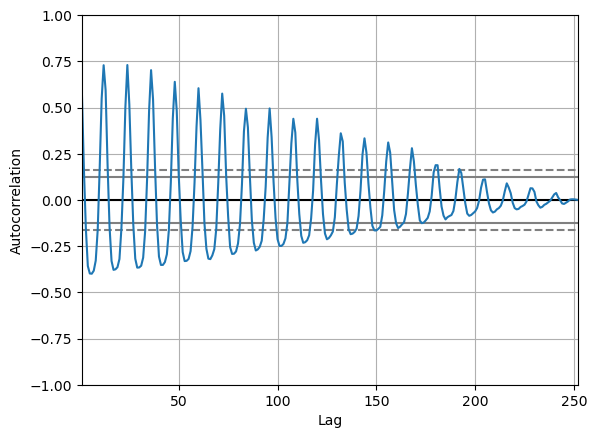

In [951]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y_clean)

The wave-like pattern in the autocorrelation plot indicates that there are periodic or seasonal patterns in your data. In this case, the up and down waves suggest that your precipitation data exhibits a cyclical trend, which is common in weather-related time series data. This means that precipitation levels are likely influenced by seasonal factors, such as the time of year (e.g., wet seasons versus dry seasons), and may repeat every certain number of months (typically a year for monthly data).

In [954]:
df_clean = pd.concat([X_clean, y_clean], axis=1)
df_clean

,Year,Month,Specific Humidity,Relative Humidity,Temperature,Precipitation
0,2000.0,1.0,8.06,48.25,23.93,0.00
1,2000.0,2.0,8.73,50.81,25.83,0.11
2,2000.0,3.0,8.48,42.88,26.68,0.01
3,2000.0,4.0,13.79,55.69,22.49,0.02
4,2000.0,5.0,17.40,70.88,19.07,271.14
...,...,...,...,...,...,...
247,2020.0,8.0,20.08,92.31,5.34,1203.09
248,2020.0,9.0,19.71,90.12,9.22,361.30
249,2020.0,10.0,18.43,82.69,12.62,180.18
250,2020.0,11.0,14.83,76.06,16.95,0.49


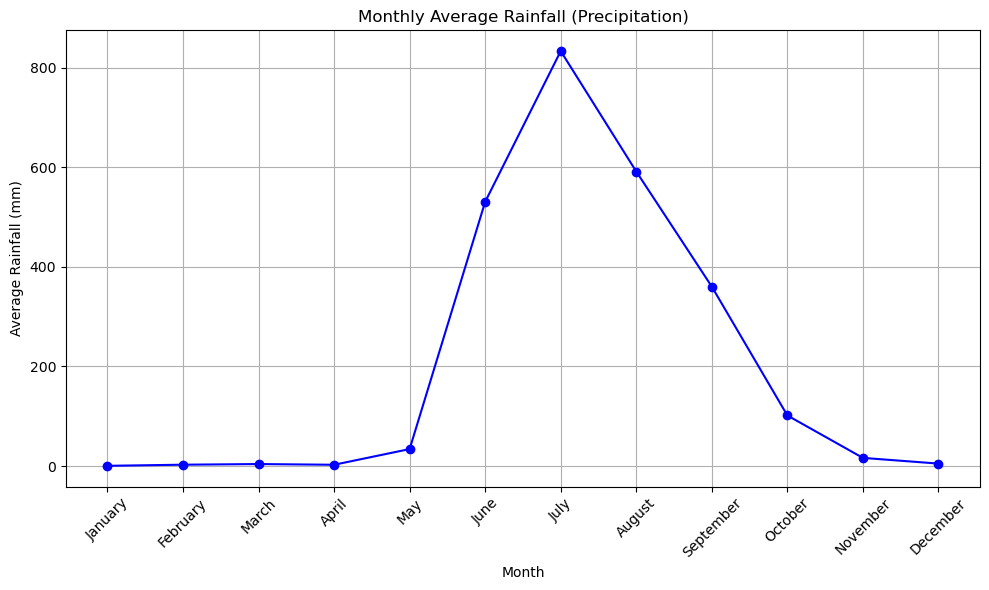

In [956]:
# Convert Year and Month into a datetime format for easier manipulation
import calendar
ddf=df_clean
ddf['Date'] = pd.to_datetime(ddf[['Year', 'Month']].assign(DAY=1))

# Group by month and compute the average for precipitation
monthly_avg_precipitation = ddf.groupby(ddf['Date'].dt.month)['Precipitation'].mean()

# Get month names
month_names = [calendar.month_name[i] for i in monthly_avg_precipitation.index]

# Plot the monthly average precipitation (rainfall)
plt.figure(figsize=(10, 6))
plt.plot(month_names, monthly_avg_precipitation.values, label='Monthly Average Rainfall', color='blue', marker='o')
plt.title('Monthly Average Rainfall (Precipitation)')
plt.xlabel('Month')
plt.ylabel('Average Rainfall (mm)')
plt.xticks(rotation=45)  # Rotate month names for better readability
plt.grid(True)
plt.tight_layout()
#plt.legend()

# Show the plot
plt.show()

In [958]:
#Feature Engineering 
df1=df_clean
df1['Month_sin'] = np.sin(2 * np.pi * df1['Month'] / 12)
df1['Month_cos'] = np.cos(2 * np.pi * df1['Month'] / 12)
df1 = df1.dropna().reset_index(drop=True)
df1.head()


,Year,Month,Specific Humidity,Relative Humidity,Temperature,Precipitation,Date,Month_sin,Month_cos
0,2000.0,1.0,8.06,48.25,23.93,0.00,2000-01-01,0.500000,8.660254e-01
1,2000.0,2.0,8.73,50.81,25.83,0.11,2000-02-01,0.866025,5.000000e-01
2,2000.0,3.0,8.48,42.88,26.68,0.01,2000-03-01,1.000000,6.123234e-17
3,2000.0,4.0,13.79,55.69,22.49,0.02,2000-04-01,0.866025,-5.000000e-01
4,2000.0,5.0,17.40,70.88,19.07,271.14,2000-05-01,0.500000,-8.660254e-01


In [960]:
df1.shape

(252, 9)

In [962]:
X = df1.drop(columns=['Precipitation'])
y = df1['Precipitation']


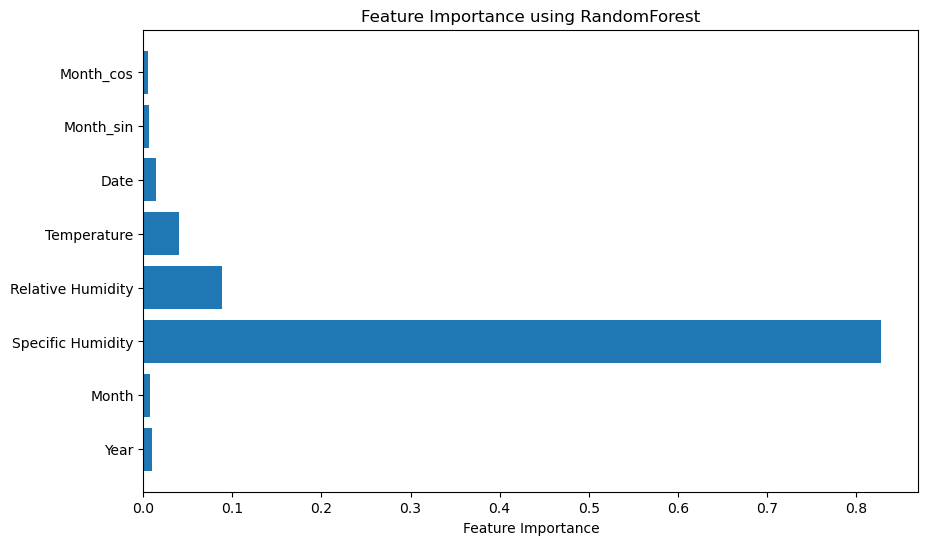

In [964]:
#Feature Selection
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

# Separate features (X) and target (y)
X = df1.drop(columns=['Precipitation'])
y = df1['Precipitation']
# Handle datetime64 columns
for col in X.select_dtypes(include=['datetime64']).columns:
    X[col] = X[col].apply(lambda x: x.timestamp() if not pd.isnull(x) else np.nan)

# Fit a RandomForest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance using RandomForest')
plt.show()


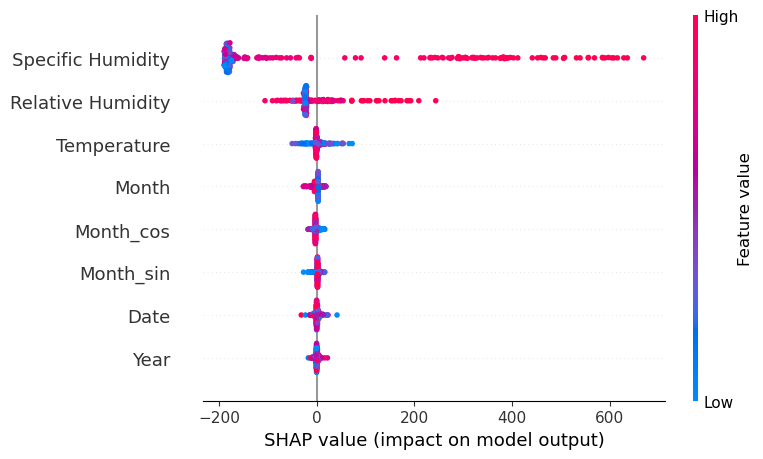

In [966]:
import shap

# Create a SHAP explainer using the trained RandomForest model
explainer = shap.TreeExplainer(model)
# Compute SHAP values for the dataset
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

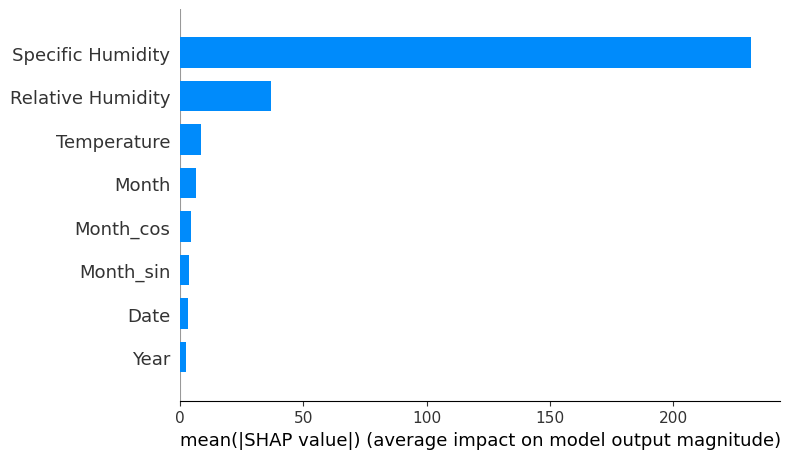

In [968]:
shap.summary_plot(shap_values, X, plot_type="bar")  # For regression, shap_values[0] is the correct array

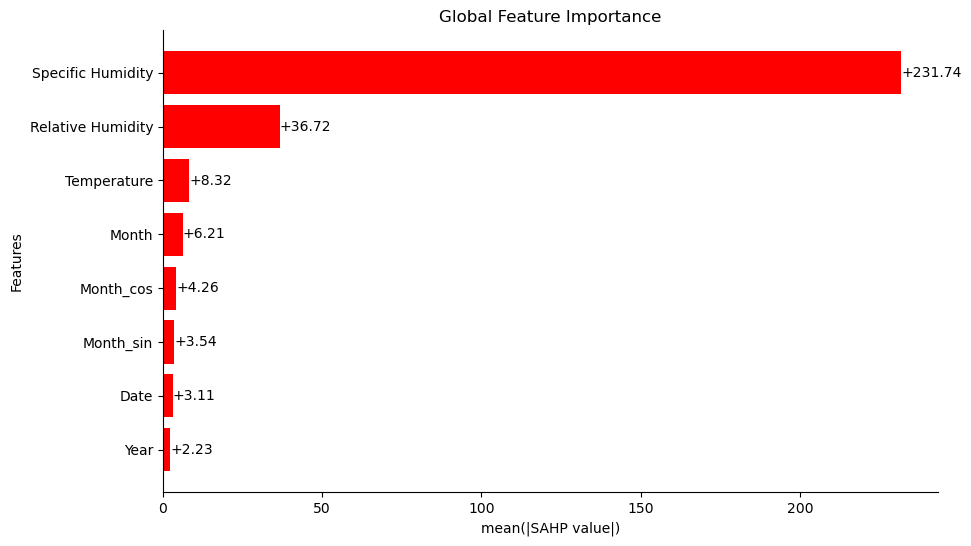

In [970]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Assuming shap_values and X are already defined
shap_values = shap_values
X = X

# Calculate mean absolute SHAP values for each feature (global importance)
global_importance = np.abs(shap_values).mean(axis=0)

# Get feature names and sort by importance
feature_names = X.columns
sorted_idx = np.argsort(global_importance)[::-1]
sorted_importance = global_importance[sorted_idx]
sorted_features = feature_names[sorted_idx]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_features, sorted_importance, color='red')

# Add global importance values with a positive sign
for bar, value in zip(bars, sorted_importance):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, f'+{value:.2f}', va='center')

plt.xlabel('mean(|SAHP value|)')
plt.ylabel('Features')
plt.title('Global Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
# Remove spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#plt.gca().spines['left'].set_visible(False)
#plt.gca().spines['bottom'].set_visible(False)

plt.show()

In [972]:
Timestamp

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
247   2020-08-01
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
Length: 252, dtype: datetime64[ns]

In [974]:
# Create a Timestamp series (replace this with your actual Timestamp series)
Timestamp = pd.to_datetime(Timestamp)

# Insert the 'Timestamp' at position 1 in DataFrame X
X.insert(1, 'Timestamp', Timestamp)
X

,Year,Timestamp,Month,Specific Humidity,Relative Humidity,Temperature,Date,Month_sin,Month_cos
0,2000.0,2000-01-01,1.0,8.06,48.25,23.93,9.466848e+08,5.000000e-01,8.660254e-01
1,2000.0,2000-02-01,2.0,8.73,50.81,25.83,9.493632e+08,8.660254e-01,5.000000e-01
2,2000.0,2000-03-01,3.0,8.48,42.88,26.68,9.518688e+08,1.000000e+00,6.123234e-17
3,2000.0,2000-04-01,4.0,13.79,55.69,22.49,9.545472e+08,8.660254e-01,-5.000000e-01
4,2000.0,2000-05-01,5.0,17.40,70.88,19.07,9.571392e+08,5.000000e-01,-8.660254e-01
...,...,...,...,...,...,...,...,...,...
247,2020.0,2020-08-01,8.0,20.08,92.31,5.34,1.596240e+09,-8.660254e-01,-5.000000e-01
248,2020.0,2020-09-01,9.0,19.71,90.12,9.22,1.598918e+09,-1.000000e+00,-1.836970e-16
249,2020.0,2020-10-01,10.0,18.43,82.69,12.62,1.601510e+09,-8.660254e-01,5.000000e-01
250,2020.0,2020-11-01,11.0,14.83,76.06,16.95,1.604189e+09,-5.000000e-01,8.660254e-01


In [976]:
# Create a Timestamp series (replace this with your actual Timestamp series)
Timestamp = pd.to_datetime(Timestamp)
y=pd.DataFrame(y, columns=['Precipitation'])
# Insert the 'Timestamp' at position 1 in DataFrame X
y.insert(1, 'Timestamp', Timestamp)
y

,Precipitation,Timestamp
0,0.00,2000-01-01
1,0.11,2000-02-01
2,0.01,2000-03-01
3,0.02,2000-04-01
4,271.14,2000-05-01
...,...,...
247,1203.09,2020-08-01
248,361.30,2020-09-01
249,180.18,2020-10-01
250,0.49,2020-11-01


In [978]:
X = X.set_index('Timestamp').sort_values(by='Timestamp')
#X

In [980]:
y = y.set_index('Timestamp').sort_values(by='Timestamp')
#y

In [982]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.base import clone
import numpy as np
import pandas as pd

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the split index for chronological split
split_index = int(len(X) * 0.8)  # 80% training, 20% testing

# Chronological split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]



In [984]:
#X_train

In [988]:
#X_test

In [990]:
#y_train

In [992]:
#y_test

In [994]:
y_train = y_train['Precipitation']
#y_train

In [996]:
y_test = y_test['Precipitation']
#y_test

In [1010]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.base import clone
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Split the data into features (X) and target (y)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Scale the features (X)
#x_scaler = StandardScaler()
x_scaler = MinMaxScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
#X_train_scaled=X_train
#X_test_scaled=X_test

# Create base models dictionary
base_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor(n_neighbors=7),
}

# Create separate instances for ensemble models
ensemble_estimators = [(name, clone(model)) for name, model in base_models.items()]

# Create full model dictionary including ensembles
model_list = base_models.copy()

# Add stacking and voting models separately
model_list['Stacking'] = StackingRegressor(estimators=ensemble_estimators)
model_list['Voting'] = VotingRegressor(estimators=ensemble_estimators)

# K-fold Cross-validation (using 5 or 10 folds)
k_folds = 10

In [1012]:
time_stamps = X_test.index 
time_stamps

DatetimeIndex(['2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)

Training Linear Regression model with 10-fold cross-validation...


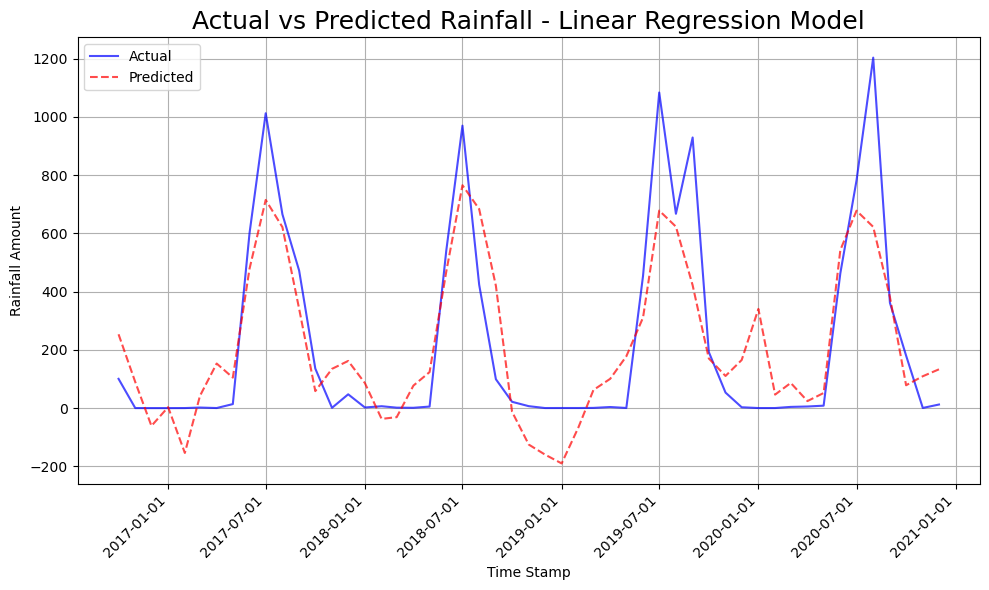

Finished training Linear Regression model.
Training Random Forest model with 10-fold cross-validation...


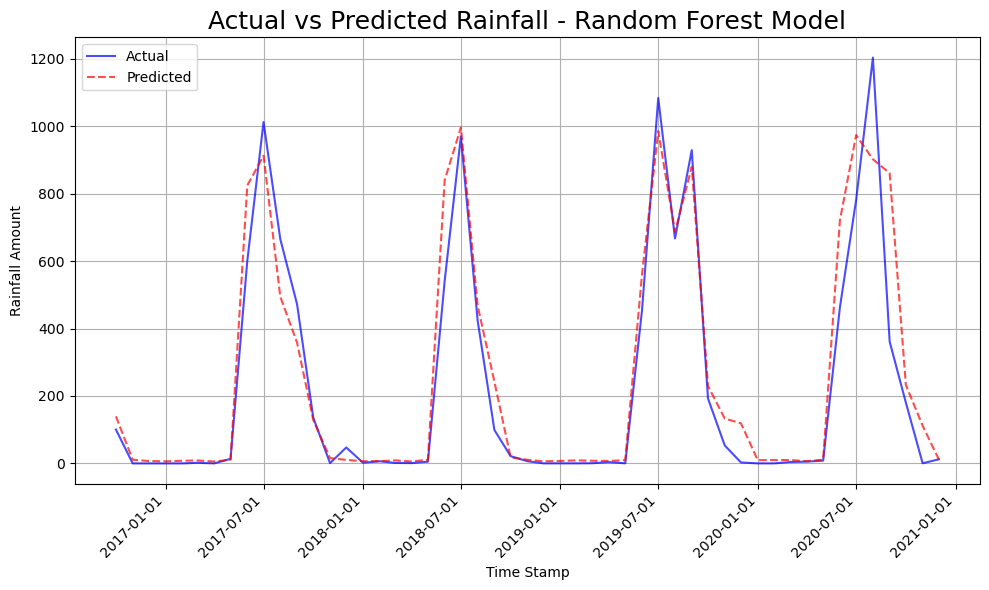

Finished training Random Forest model.
Training XGBoost model with 10-fold cross-validation...


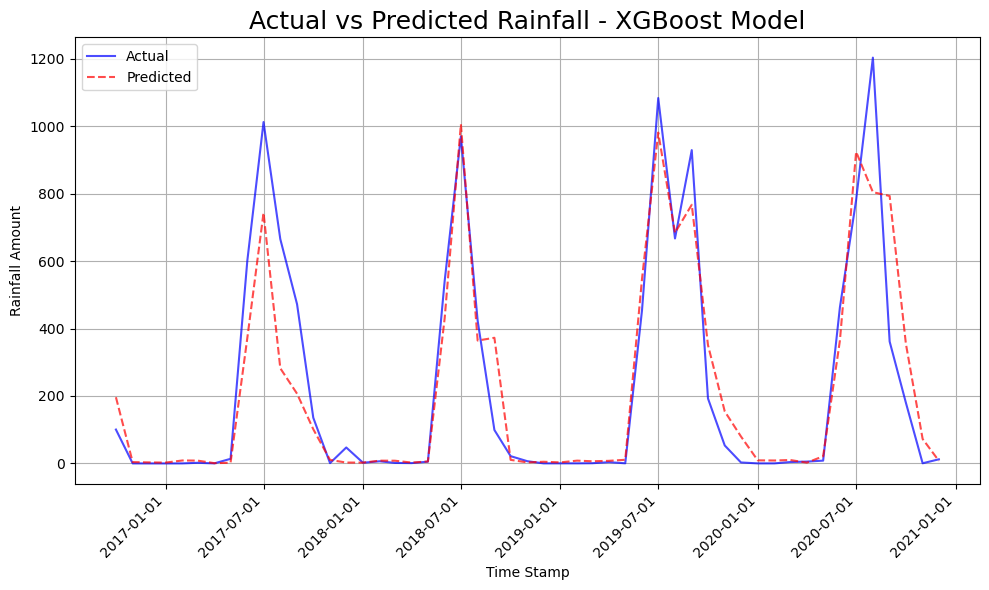

Finished training XGBoost model.
Training Gradient Boosting model with 10-fold cross-validation...


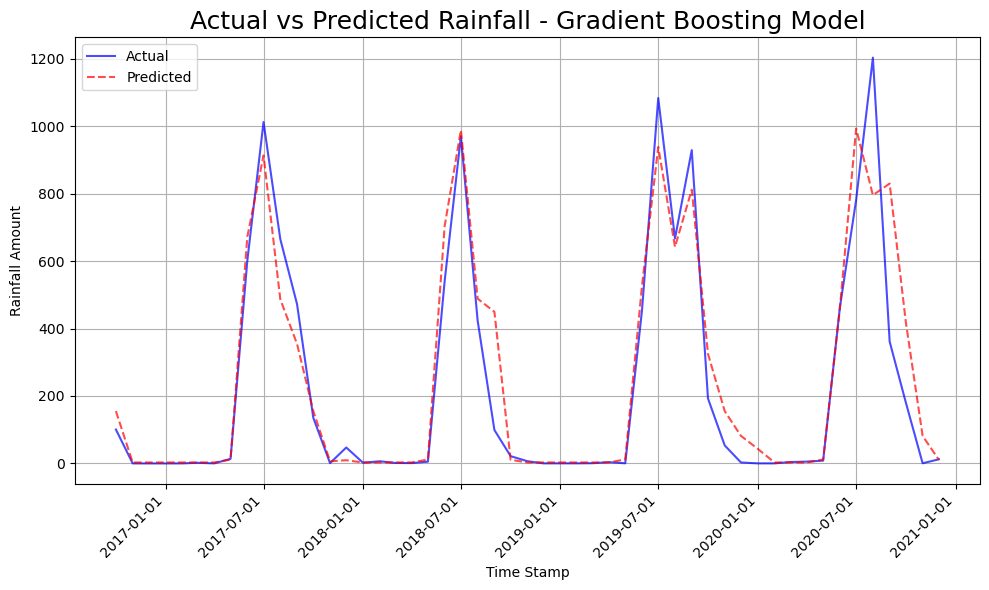

Finished training Gradient Boosting model.
Training KNN model with 10-fold cross-validation...


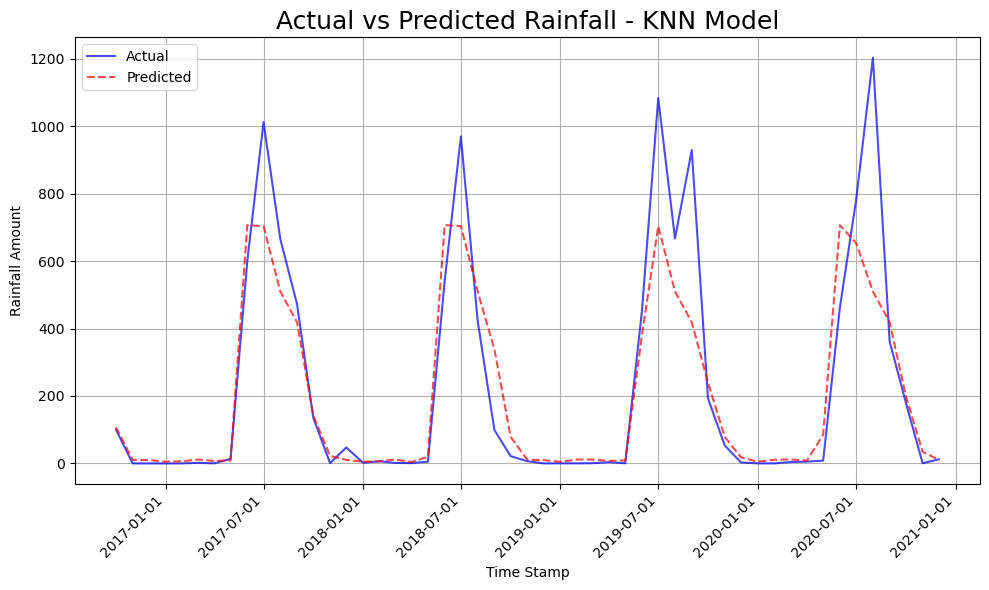

Finished training KNN model.
Training Stacking model with 10-fold cross-validation...


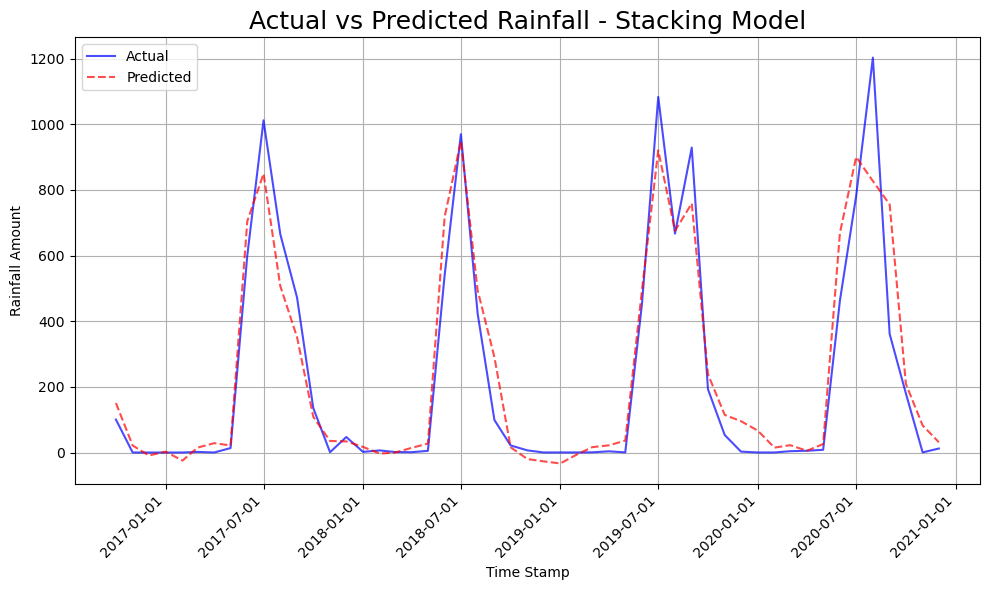

Finished training Stacking model.
Training Voting model with 10-fold cross-validation...


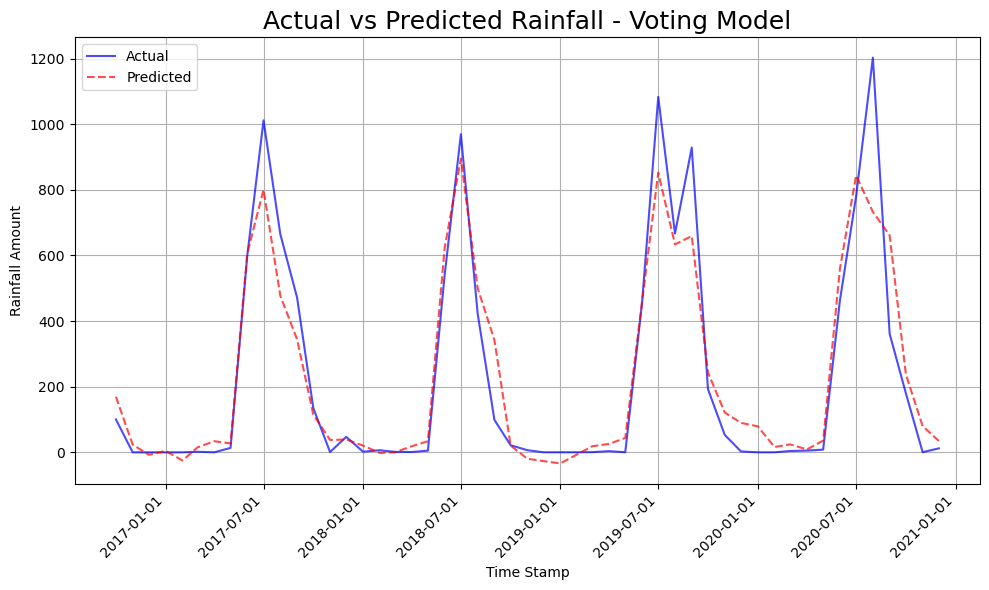

Finished training Voting model.


,Model,CV_MSE,CV_RMSE,CV_MAE,CV_R2,Test_MSE,Test_RMSE,Test_MAE,Test_R2
5,Stacking,0.012252,0.110691,16.019178,0.782054,0.006896,0.083043,0.050896,0.900753
6,Voting,0.012346,0.111114,16.141979,0.780384,0.007734,0.087944,0.052458,0.888691
1,Random Forest,0.012730,0.112827,16.643435,0.773561,0.008284,0.091016,0.049333,0.880780
3,Gradient Boosting,0.016803,0.129627,21.969100,0.701104,0.009062,0.095192,0.050752,0.869587
2,XGBoost,0.016604,0.128856,21.708326,0.704652,0.010846,0.104142,0.059713,0.843911
4,KNN,0.012928,0.113699,16.901865,0.770045,0.015006,0.122497,0.062024,0.784042
0,Linear Regression,0.016820,0.129691,21.990692,0.700810,0.018595,0.136364,0.101726,0.732380


Styled DataFrame saved to model_metrics.xlsx


In [1014]:
# Training and evaluation loop with test data evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.dates as mdates


results = []
for key, model in model_list.items():
    print(f"Training {key} model with {k_folds}-fold cross-validation...")

    # Perform K-fold cross-validation (without scaling y)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=k_folds, scoring='neg_mean_squared_error')

    # Calculate metrics from the cross-validation scores
    mse_cv = -cv_scores.mean()  # since cross_val_score returns negative MSE
    rmse_cv = np.sqrt(mse_cv)
    mae_cv = np.mean(np.abs(cv_scores))  # calculate MAE as the average of the absolute errors
    # Calculate MAE based on cross-validation predictions
    r2_cv = 1 - (mse_cv / np.var(y_train))  # calculate R-squared
    # Calculate R² for cross-validation
    
    
    # Scale the metrics to a 0-1 range
    max_possible_mse = np.square(max(y_train) - min(y_train))
    scaled_mse_cv = mse_cv / max_possible_mse
    scaled_rmse_cv = rmse_cv / (max(y_train) - min(y_train))
    scaled_mae_cv = mae_cv / (max(y_train) - min(y_train))
    scaled_r2_cv = max(0, min(1, r2_cv))


    # Train the model on the entire training set
    model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred_test = model.predict(X_test_scaled)
    #------------------------------------------------------------
    #time_stamps = X_test.index  # row index contains the time stamps
    time_stamps = pd.to_datetime(time_stamps) 
    """plt.figure(figsize=(10, 6))
    plt.plot(time_stamps, y_test, label='Actual', color='blue', alpha=0.7)
    plt.plot(time_stamps, y_pred_test, label='Predicted', color='red', linestyle='--', alpha=0.7)
    plt.title(f"Actual vs Predicted Rainfall - {key} Model")
    plt.xlabel("Time Stamp")
    plt.ylabel("Rainfall Amount")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate time stamps on x-axis for better readability
    plt.tight_layout()
    plt.show()
    # Scatter plot for Actual values (blue points)
    plt.figure(figsize=(10, 6))
    plt.scatter(time_stamps, y_test, label='Actual', color='blue', alpha=0.7, marker='o')
    
    # Scatter plot for Predicted values (red points)
    plt.scatter(time_stamps, y_pred_test, label='Predicted', color='red', alpha=0.7, marker='x')
    
    plt.title(f"Actual vs Predicted Rainfall - {key} Model")
    plt.xlabel("Time Stamp")
    plt.ylabel("Rainfall Amount")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate time stamps on x-axis for better readability
    plt.tight_layout()
    plt.show()"""
    plt.figure(figsize=(10, 6))

    # Scatter plot for Actual values (blue points)
    #plt.scatter(time_stamps, y_test, label='Actual', color='blue', alpha=0.7, marker='o')

    # Scatter plot for Predicted values (red points)
    #plt.scatter(time_stamps, y_pred_test, label='Predicted', color='red', alpha=0.7, marker='x')
    plt.plot(time_stamps, y_test, label='Actual', color='blue', alpha=0.7)
    plt.plot(time_stamps, y_pred_test, label='Predicted', color='red', linestyle='--', alpha=0.7)

    # Format x-axis to show full date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust tick frequency

    plt.title(f"Actual vs Predicted Rainfall - {key} Model",fontsize=18)
    plt.xlabel("Time Stamp")
    plt.ylabel("Rainfall Amount")
    plt.legend()
    plt.grid(True)

    # Rotate and align the x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    
    #-------------------------------------------------------
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    # Scale the test metrics to a 0-1 range
    scaled_mse_test = mse_test / max_possible_mse
    scaled_rmse_test = rmse_test / (max(y_train) - min(y_train))
    scaled_mae_test = mae_test / (max(y_train) - min(y_train))
    scaled_r2_test = max(0, min(1, r2_test))

    
    # Collect results
    results.append({
        'Model': key,
        'CV_MSE': scaled_mse_cv,
        'CV_RMSE': scaled_rmse_cv,
        'CV_MAE': scaled_mae_cv,
        'CV_R2': scaled_r2_cv,
        'Test_MSE': scaled_mse_test,
        'Test_RMSE': scaled_rmse_test,
        'Test_MAE': scaled_mae_test,
        'Test_R2': scaled_r2_test
    })

    print(f"Finished training {key} model.")

# Create and display results DataFrame
model_metrics_df = pd.DataFrame(results)
sorted_df = model_metrics_df.sort_values(by='Test_MSE', ascending=True)
styled_df = sorted_df.style.background_gradient(cmap='viridis', 
                                                subset=['CV_MSE', 'Test_MSE', 'CV_R2', 'Test_R2'])
display(styled_df)

file_name = "model_metrics.xlsx"
# Save styled DataFrame to an Excel file
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    styled_df.to_excel(writer, sheet_name='Metrics', index=False)

print(f"Styled DataFrame saved to {file_name}")


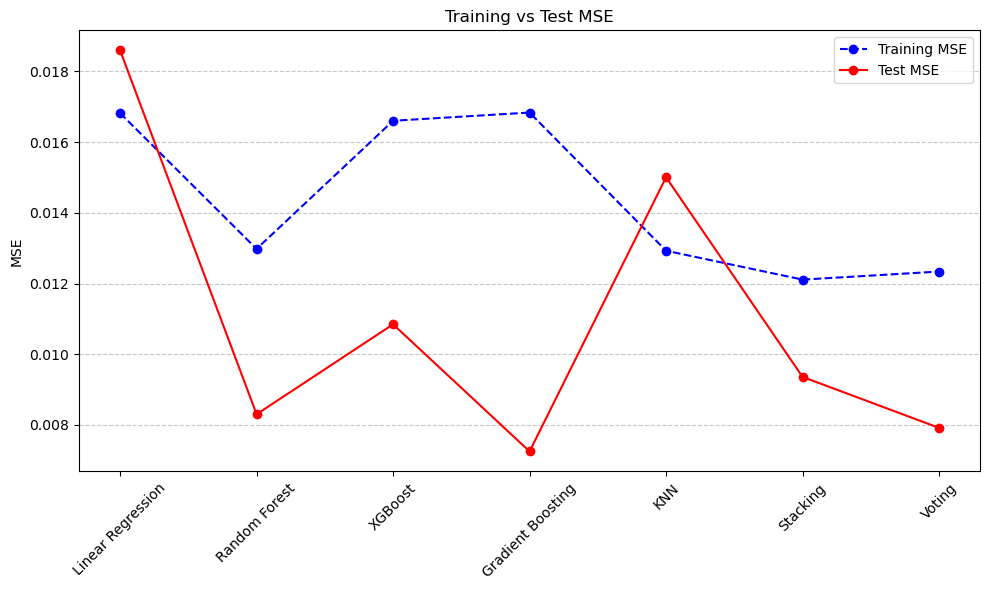

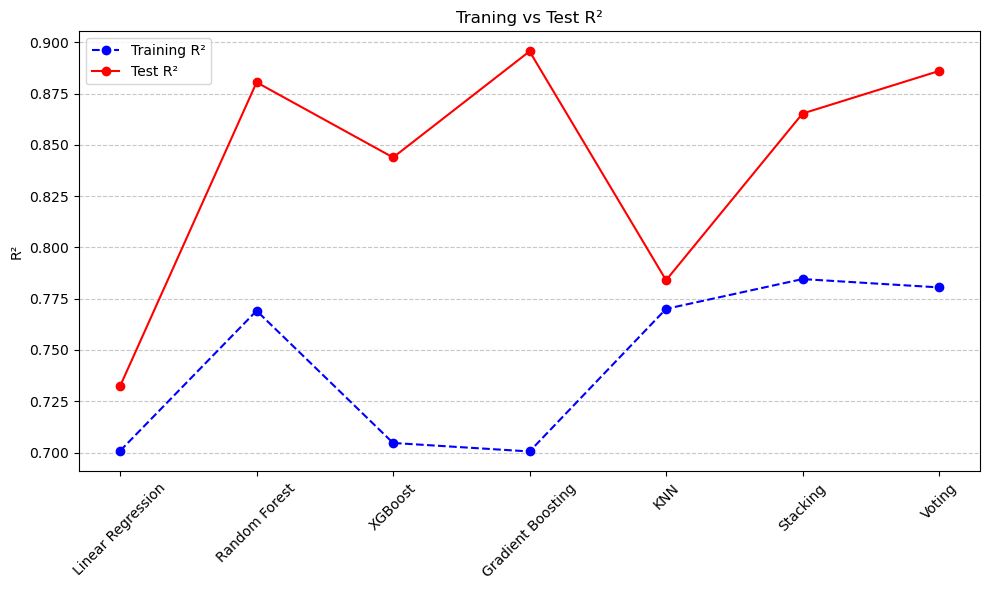

In [873]:
import matplotlib.pyplot as plt

# Extract values for plotting
models = model_metrics_df['Model']
cv_mse = model_metrics_df['CV_MSE']
test_mse = model_metrics_df['Test_MSE']
cv_r2 = model_metrics_df['CV_R2']
test_r2 = model_metrics_df['Test_R2']

# Plot MSE for CV vs Test
plt.figure(figsize=(10, 6))
plt.plot(models, cv_mse, marker='o', label='Training MSE', color='blue', linestyle='--')
plt.plot(models, test_mse, marker='o', label='Test MSE', color='red', linestyle='-')

plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.title('Training vs Test MSE')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² for CV vs Test
plt.figure(figsize=(10, 6))
plt.plot(models, cv_r2, marker='o', label='Training R²', color='blue', linestyle='--')
plt.plot(models, test_r2, marker='o', label='Test R²', color='red', linestyle='-')

plt.xticks(rotation=45)
plt.ylabel('R²')
plt.title('Traning vs Test R²')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [874]:
df = pd.read_csv('MLSP.csv')

# 2. Prepare features and target
features = ['Specific Humidity','Relative Humidity', 'Temperature']
target = 'Precipitation'

# Convert DATE column to datetime
df['Timestamp'] = pd.to_datetime(df[['Year', 'Month','Day']])

df = df.set_index('Timestamp')
df = df.sort_values(by='Timestamp')
df

,Year,Month,Day,Specific Humidity,Relative Humidity,Temperature,Precipitation
Timestamp,,,,,,,
2000-01-01,2000,1,1,8.06,48.25,23.93,0.00
2000-02-01,2000,2,1,8.73,50.81,25.83,0.11
2000-03-01,2000,3,1,8.48,42.88,26.68,0.01
2000-04-01,2000,4,1,13.79,55.69,22.49,0.02
2000-05-01,2000,5,1,17.40,70.88,19.07,271.14
...,...,...,...,...,...,...,...
2020-08-01,2020,8,1,20.08,92.31,5.34,1203.09
2020-09-01,2020,9,1,19.71,90.12,9.22,361.30
2020-10-01,2020,10,1,18.43,82.69,12.62,180.18


In [875]:
df = df.drop(['Year', 'Month', 'Day'], axis=1)
df

,Specific Humidity,Relative Humidity,Temperature,Precipitation
Timestamp,,,,
2000-01-01,8.06,48.25,23.93,0.00
2000-02-01,8.73,50.81,25.83,0.11
2000-03-01,8.48,42.88,26.68,0.01
2000-04-01,13.79,55.69,22.49,0.02
2000-05-01,17.40,70.88,19.07,271.14
...,...,...,...,...
2020-08-01,20.08,92.31,5.34,1203.09
2020-09-01,19.71,90.12,9.22,361.30
2020-10-01,18.43,82.69,12.62,180.18


/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.28644D+00    |proj g|=  4.41718D-02

At iterate    5    f=  6.26210D+00    |proj g|=  3.48376D-03

At iterate   10    f=  6.25790D+00    |proj g|=  2.71438D-03

At iterate   15    f=  6.11609D+00    |proj g|=  1.73211D-02

At iterate   20    f=  6.11571D+00    |proj g|=  1.57582D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   2.530D-06   6.116D+00
  F =   6.1157112616590785     

CONVERG

/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


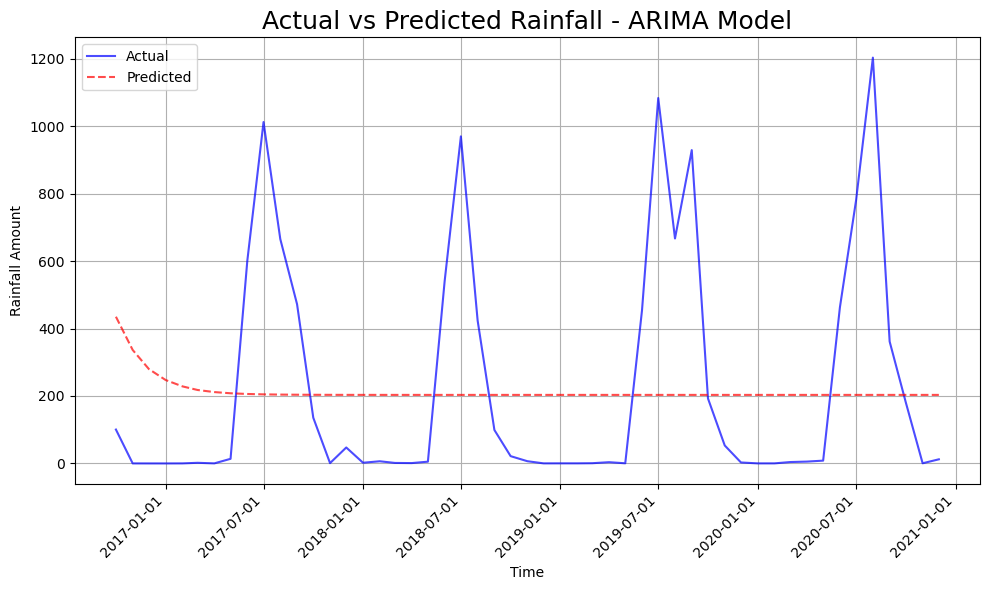

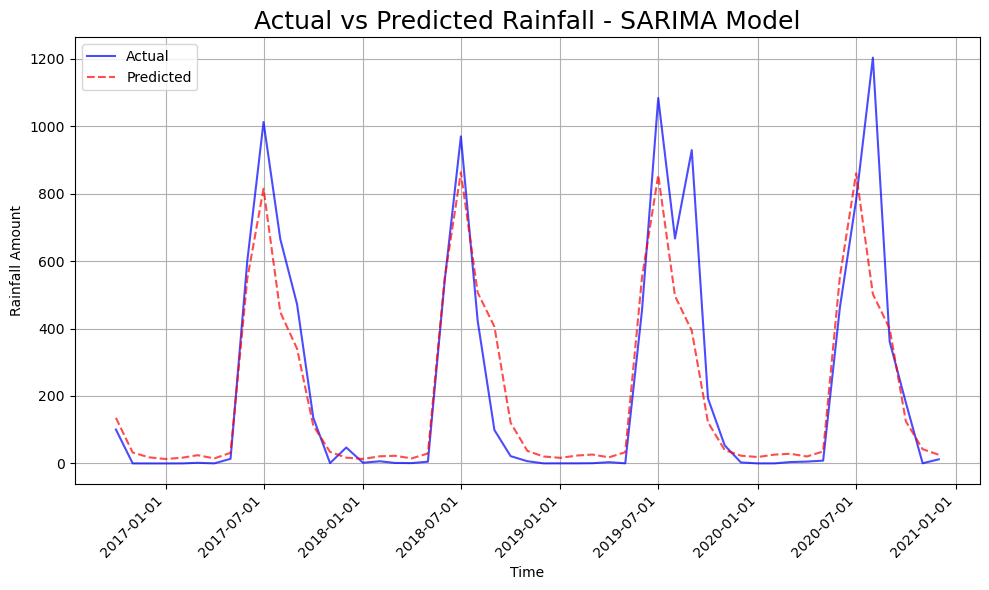

In [876]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Split data into training and testing
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

def calculate_scaled_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    max_possible_mse = np.square(max(y_true) - min(y_true))
    scaled_mse = mse / max_possible_mse

    rmse = np.sqrt(mse)
    scaled_rmse = rmse / (max(y_true) - min(y_true))

    max_possible_mae = max(y_true) - min(y_true)
    scaled_mae = mae / max_possible_mae

    scaled_r2 = max(0, min(1, r2))

    return {
        "Scaled MSE": scaled_mse,
        "Scaled RMSE": scaled_rmse,
        "Scaled MAE": scaled_mae,
        "Scaled R²": scaled_r2,
    }

def plot_predictions(test, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.plot(time_stamps, test[target], label='Actual', color='blue', alpha=0.7)
    plt.plot(time_stamps, predictions, label='Predicted', color='red',linestyle='--', alpha=0.7)
    # Format x-axis to show full date
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust tick frequency
    plt.title(title,fontsize=18)
    plt.xlabel('Time')
    plt.ylabel('Rainfall Amount')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Define parameters for SARIMA and ARIMA
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s)

# SARIMA Model
sarima_model = SARIMAX(train[target], order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()
sarima_pred = sarima_result.forecast(len(test))

# ARIMA Model
arima_model = SARIMAX(train[target], order=order)
arima_result = arima_model.fit(disp=False)
arima_pred = arima_result.get_forecast(steps=len(test)).predicted_mean

# Calculate metrics for ARIMA
arima_metrics = calculate_scaled_metrics(test[target], arima_pred)
print("ARIMA Metrics:")
for metric, value in arima_metrics.items():
    print(f"{metric}: {value:.4f}")

# Calculate metrics for SARIMA
sarima_metrics = calculate_scaled_metrics(test[target], sarima_pred)
print("\nSARIMA Metrics:")
for metric, value in sarima_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot predictions
plot_predictions(test, arima_pred, 'Actual vs Predicted Rainfall - ARIMA Model')
plot_predictions(test, sarima_pred, 'Actual vs Predicted Rainfall - SARIMA Model')



Epoch 1/100


/Users/elhampashaei/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0802 - val_loss: 0.0715
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0641 - val_loss: 0.0628
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0565 - val_loss: 0.0585
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0561 - val_loss: 0.0566
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0557 - val_loss: 0.0557
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0541 - val_loss: 0.0549
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0481 - val_loss: 0.0542
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0522 - val_loss: 0.0534
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0446 - val_loss: 0.0524
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0547 - val_loss: 0.0512
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0439 - val_loss: 0.0501
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0440 - val_loss: 0.0485
Epoch 13/100

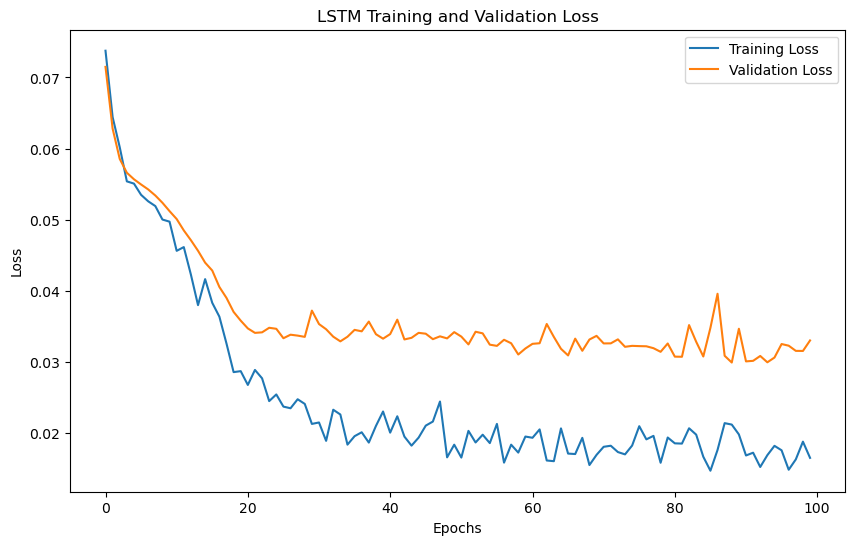

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


array([[-3.97475436e-03],
       [ 1.67337134e-02],
       [ 1.07261449e-01],
       [ 3.92323822e-01],
       [ 6.28407001e-01],
       [ 5.61341226e-01],
       [ 2.27736145e-01],
       [ 6.13607951e-02],
       [ 2.44606379e-02],
       [ 1.62419863e-02],
       [ 1.62533000e-02],
       [ 1.78643335e-02],
       [ 2.40062941e-02],
       [ 2.39643138e-02],
       [ 2.15989742e-02],
       [ 3.49708378e-01],
       [ 5.91486812e-01],
       [ 4.99007046e-01],
       [ 1.93396151e-01],
       [ 6.25736341e-02],
       [ 2.62737498e-02],
       [ 1.45500787e-02],
       [ 9.72202420e-03],
       [ 1.19548067e-02],
       [ 1.39873475e-04],
       [-1.98827498e-02],
       [ 9.44574773e-02],
       [ 2.91639656e-01],
       [ 5.98323822e-01],
       [ 5.91090083e-01],
       [ 2.97684878e-01],
       [ 8.14547166e-02],
       [ 3.14215198e-02],
       [ 1.52832530e-02],
       [ 1.74762867e-02],
       [ 1.53232515e-02],
       [ 1.82780419e-02],
       [ 1.55474693e-02],
       [ 9.7

In [1044]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

def calculate_scaled_metrics(y_true, y_pred, model_name):
    """Calculate scaled evaluation metrics for a model."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    max_possible_mse = np.square(max(y_true) - min(y_true))
    max_possible_mae = max(y_true) - min(y_true)
    
    scaled_mse = mse / max_possible_mse
    scaled_rmse = rmse / (max(y_true) - min(y_true))
    scaled_mae = mae / max_possible_mae
    scaled_r2 = max(0, min(1, r2))
    
    return {
        'Model': model_name,
        'Scaled_MSE': scaled_mse,
        'Scaled_RMSE': scaled_rmse,
        'Scaled_MAE': scaled_mae,
        'Scaled_R²': scaled_r2
    }

# Load and prepare data
df = pd.read_csv('MLSP.csv')
features = ['Specific Humidity', 'Relative Humidity', 'Temperature']
target = 'Precipitation'

df['Timestamp'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df = df.set_index('Timestamp').sort_values(by='Timestamp')
df = df.drop(['Year', 'Month', 'Day'], axis=1)

# Split data
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size:]

# 1. LSTM Model
def prepare_lstm_data(data, time_steps, features, target):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :len(features)])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

# Scale data for LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[features + [target]])
test_scaled = scaler.transform(test[features + [target]])
#train_scaled=train[features + [target]]
#test_scaled=test[features + [target]]

# Prepare sequences
time_steps = 5
X_train, y_train = prepare_lstm_data(train_scaled, time_steps, features, target)
X_test, y_test = prepare_lstm_data(test_scaled, time_steps, features, target)

# Build and train LSTM model
model = Sequential([
    LSTM(30, activation='relu', input_shape=(time_steps, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(15, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Get LSTM predictions
lstm_pred = model.predict(X_test)
lstm_pred

# 2. Placeholder for SARIMA/ARIMA Implementation (if needed)
# Add similar logic for SARIMA or ARIMA models if desired.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
LSTM Model Metrics:
Model: LSTM
Scaled_MSE: 0.0149
Scaled_RMSE: 0.1219
Scaled_MAE: 0.0729
Scaled_R²: 0.8299


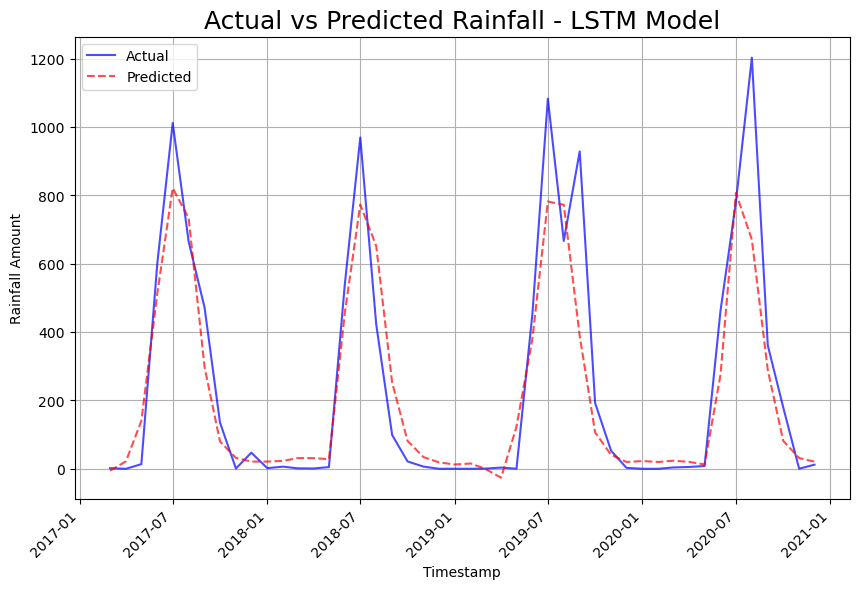

In [1046]:
# Create a placeholder with the same number of features as the scaler expects
lstm_pred = model.predict(X_test)
if lstm_pred.ndim == 3:
    lstm_pred = lstm_pred[:, -1, :]  # Extract last time step

# Perform inverse scaling
padding = np.zeros((lstm_pred.shape[0], len(features)))
lstm_pred_full = np.concatenate([padding, lstm_pred], axis=1)
lstm_pred = scaler.inverse_transform(lstm_pred_full)[:, -1]

y_test_full = np.concatenate([padding, y_test.reshape(-1, 1)], axis=1)
y_test_actual = scaler.inverse_transform(y_test_full)[:, -1]


# Evaluate LSTM model
metrics = calculate_scaled_metrics(y_test_actual, lstm_pred, 'LSTM')
print("LSTM Model Metrics:")
for metric, value in metrics.items():
    if isinstance(value, float):  # Format only numerical values
        print(f"{metric}: {value:.4f}")
    else:  # Print non-numerical values as they are
        print(f"{metric}: {value}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index[time_steps:], y_test_actual, label='Actual',color='blue', alpha=0.7)
plt.plot(test.index[time_steps:], lstm_pred, label='Predicted',color='red',linestyle='--', alpha=0.7)
plt.title('Actual vs Predicted Rainfall - LSTM Model',fontsize=18)
plt.xlabel('Timestamp')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
#plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically adjust tick frequency
plt.ylabel('Rainfall Amount')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

In [878]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi



# Data
data = {
    "Model": ["Stacking", "Voting", "Random Forest", "Gradient Boosting", "XGBoost", 
              "KNN", "Linear Regression", "ARIMA", "SARIMA", "LSTM"],
    "MSE": [0.006883162,0.007674081,0.007880635,0.007931424,0.00842944,0.014342933,0.018579098, 0.0858, 0.0154, 0.0139],
    "RMSE": [0.082964825,0.087601831,0.08877294,0.089058542,0.09181198,0.119761983,0.136305165, 0.2929, 0.1242, 0.1181],
    "MAE": [0.048475006,0.05325327,0.046990937,0.048613263,0.051180509,0.0562271,0.101706829, 0.2366, 0.0648, 0.0715],
    "R2": [0.900938591,0.889555813,0.886583119,0.885852171,0.878684804,0.793578728,0.732612487, 0.0, 0.8120, 0.8404]
}


df = pd.DataFrame(data)

# Round metrics to 3 decimal places
metrics = ["MSE", "RMSE", "MAE", "R2"]
df[metrics] = df[metrics].round(4)
df

,Model,MSE,RMSE,MAE,R2
0,Stacking,0.0069,0.0830,0.0485,0.9009
1,Voting,0.0077,0.0876,0.0533,0.8896
2,Random Forest,0.0079,0.0888,0.0470,0.8866
3,Gradient Boosting,0.0079,0.0891,0.0486,0.8859
4,XGBoost,0.0084,0.0918,0.0512,0.8787
5,KNN,0.0143,0.1198,0.0562,0.7936
6,Linear Regression,0.0186,0.1363,0.1017,0.7326
7,ARIMA,0.0858,0.2929,0.2366,0.0000
8,SARIMA,0.0154,0.1242,0.0648,0.8120
9,LSTM,0.0139,0.1181,0.0715,0.8404


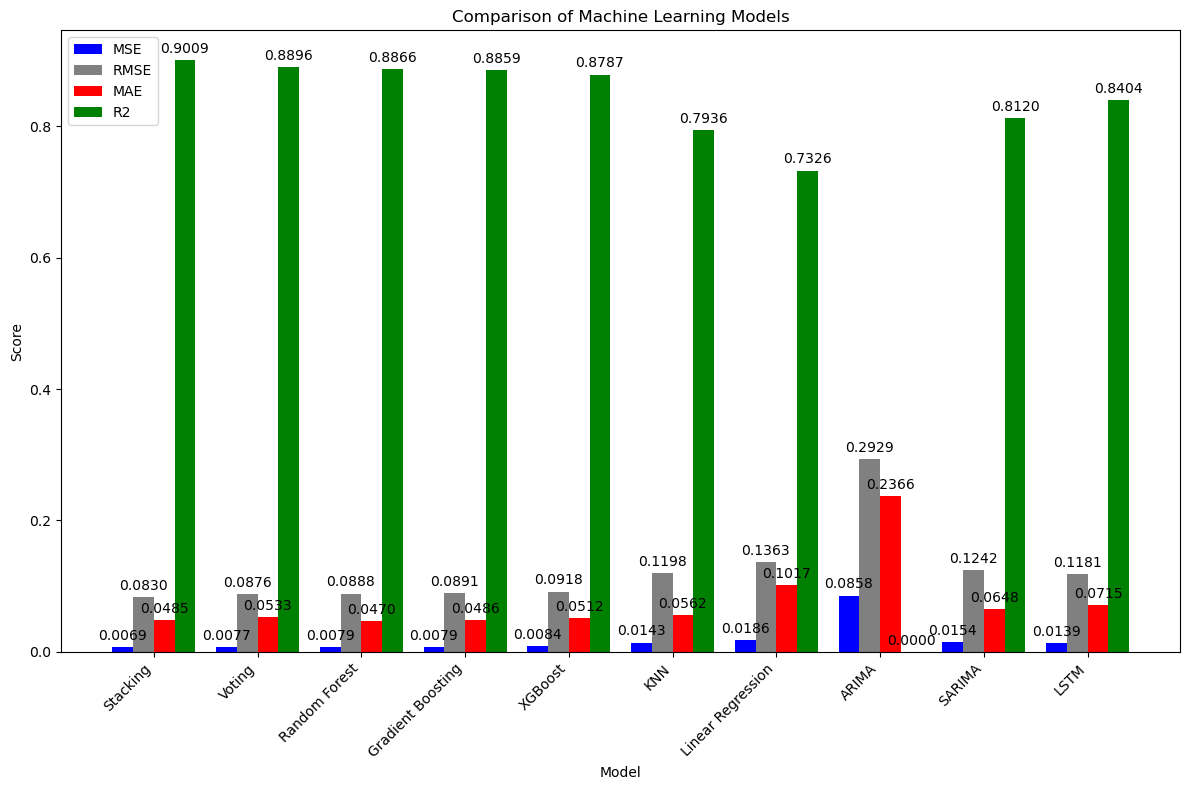

In [879]:
# Set the position for the bars
x = np.arange(len(df['Model']))  # the label locations

# Width of the bars
width = 0.2

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Create bar plots for each metric
rects1 = ax.bar(x - 1.5*width, df['MSE'], width, label='MSE', color='blue')
rects2 = ax.bar(x - 0.5*width, df['RMSE'], width, label='RMSE', color='grey')
rects3 = ax.bar(x + 0.5*width, df['MAE'], width, label='MAE', color='red')
rects4 = ax.bar(x + 1.5*width, df['R2'], width, label='R2', color='green')

# Add text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Comparison of Machine Learning Models')
ax.set_xticks(x)
ax.set_xticklabels(df['Model'], rotation=45, ha="right")
ax.legend()

# Add data labels on top of each bar
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each bar in the bar plot
add_labels(rects1)
add_labels(rects2)
add_labels(rects3)
add_labels(rects4)

# Adjust the layout for better visualization
fig.tight_layout()

# Show the plot
plt.show()
